# K-Means Clustering — PyTorch (GPU-Accelerated)

K-Means implementation using PyTorch GPU tensors. Same Lloyd's algorithm as No-Framework, but distance computation and centroid updates run on CUDA cores.

**Dataset**: Dry Beans — 13,543 samples, 16 geometric features, 7 bean types.

## PyTorch Advantages for K-Means
- **`torch.cdist`**: GPU-accelerated pairwise distance computation
- **`torch.argmin`**: Parallel cluster assignment across all samples
- **Boolean masking on GPU**: Efficient centroid updates
- **`torch.multinomial`**: GPU-native weighted random sampling for K-Means++ init

## PyTorch-Specific Showcases
- **`torch.compile`**: JIT-compiles K-Means into optimized GPU kernels (PyTorch 2.0+)
- **`torch.vmap`**: Vectorizes n_init runs to execute in parallel on GPU instead of sequentially


In [1]:
# Imports and configuration

# standard libraries
import sys
import os
import numpy as np

# pytorch for gpu computation
import torch

# add project root to path
sys.path.append(os.path.abspath('../..'))

# project utilities
from utils.data_loader import load_processed_data
from utils.metrics import inertia, silhouette_score, adjusted_rand_index
from utils.visualization import (plot_elbow_curve, plot_silhouette_comparison,
                                  plot_silhouette_analysis, plot_convergence_curve)
from utils.performance import track_performance
from utils.results import save_results, add_result, print_comparison

# Constants across all frameworks
RANDOM_STATE = 113
K_RANGE = range(2, 13)        # Test K=2 through K=12
MAX_ITER = 300                 # Maximum iterations per run
TOL = 1e-4                     # Convergence tolerance (max centroid shift)
N_INIT = 5                     # Number of random initializations
FRAMEWORK = 'PyTorch'

# GPU detection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Data loading
X_train, X_test, y_train, y_test, metadata = load_processed_data('kmeans')

print("=" * 60)
print(f"Dataset: {metadata['dataset']}")
print(f"Train: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test: {X_test.shape[0]} samples")
print(f"Classes: {metadata['n_classes']} bean types")
print("=" * 60)

# Convert to gpu tensors
# Move data to GPU - all k-means computation happens on cuda tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)

print(f"\nTensors on: {X_train_t.device}")
print(f"X_train_t: {X_train_t.shape}")
print(f"X_test_t:  {X_test_t.shape}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4090
VRAM: 25.8 GB
Dataset: Dry Beans (UCI ML Repository)
Train: 10834 samples, 16 features
Test: 2709 samples
Classes: 7 bean types

Tensors on: cuda:0
X_train_t: torch.Size([10834, 16])
X_test_t:  torch.Size([2709, 16])


In [2]:
# Step 1: k-means++ initalization (GPU)

def kmeans_pp_init_gpu(X, k, rng):
    """
    K-means++ initalization on GPU tensors.

    Selects initial centroids with probability proportional to
    squared distance from nearest existing centroid. This spreads
    centroids apart for faster convergence vs random init.

    Args:
        X: training data tensor (n_samples, n_features) on GPU
        k: number of clusters
        rng: torch.Generator for reproducibility

    Returns:
        centroids: tensor (k, n_features) on GPU
    """
    n_samples, n_features = X.shape
    centroids = torch.empty(k, n_features, device=X.device)

    # First centroid: random data point
    idx = torch.randint(n_samples, (1,), generator=rng, device=X.device)
    centroids[0] = X[idx]

    # Remaining centroids: weighted by squared distance to nearest centroid
    for i in range(1, k):
        # torch.cdist computes all pairwise distances on GPU
        # Shape: (n_samples, i) - distance from each point to each centroid so far
        dists = torch.cdist(X, centroids[:i], p=2)

        # Min distance to nearest existing centroid
        min_dists = dists.min(dim=1).values

        # Square distances for prability weights
        weights = min_dists ** 2

        # torch.multinomial: GPU-native weighted random sampling
        # draw 1 index with probability proportional to weights
        idx = torch.multinomial(weights, 1, generator=rng)
        centroids[i] = X[idx]

    return centroids

# Quick test — initialize 7 centroids on GPU
torch.manual_seed(RANDOM_STATE)
rng = torch.Generator(device=device)
rng.manual_seed(RANDOM_STATE)

test_centroids = kmeans_pp_init_gpu(X_train_t, k=7, rng=rng)
print("K-Means++ Init GPU")
print("=" * 60)
print(f"Centroids shape: {test_centroids.shape}")
print(f"Device: {test_centroids.device}")
print(f"First centroid (first 5 features): {test_centroids[0, :5]}")

K-Means++ Init GPU
Centroids shape: torch.Size([7, 16])
Device: cuda:0
First centroid (first 5 features): tensor([0.6004, 0.7514, 0.7243, 0.7972, 0.0863], device='cuda:0')


In [3]:
# Step 2: Assign Clusters (GPU)

def assign_clusters_gpu(X, centroids):
    """
    Assign each sample to nearest centroids using gpu-accelerated distances.

    Uses torch.cdist for pairwise euclidean distances - single gpu kernel
    replaces the manual broadcasting shown in no-framework.

    Args:
        X: data tensor (n_samples, n_features) on GPU
        centroids: current centroids (k, n_features) on GPU

    Returns:
        labels: cluster assignments (n_samples,) as int64 tensor
        distances: distance to assigned centroid (n_samples,)
    """
    # torch.cdist computes all pairwise distances in one gpu operation
    # shape: (n_samples, k) - distance from each point to each centroid
    all_dists = torch.cdist(X, centroids, p=2)

    # torch.min returns (values, indices) - indices are cluster assignments
    distances, labels = all_dists.min(dim=1)

    return labels, distances

# Quick test
test_labels, test_dists = assign_clusters_gpu(X_train_t, test_centroids)
print("Cluster Assignment (GPU)")
print("=" * 60)
print(f"Labels shape: {test_labels.shape}")
print(f"Labels device: {test_labels.device}")
print(f"Unique clusters: {torch.unique(test_labels).tolist()}")
print(f"Cluster sizes: {[int((test_labels == i).sum()) for i in range(7)]}")

Cluster Assignment (GPU)
Labels shape: torch.Size([10834])
Labels device: cuda:0
Unique clusters: [0, 1, 2, 3, 4, 5, 6]
Cluster sizes: [1056, 777, 2700, 4078, 409, 552, 1262]


In [4]:
# Step 3: Update centroids (GPU)

def update_centroids_gpu(X, labels, k, rng):
    """
    Recompute centroids as mean of assigned samples on GPU.

    Empty clusters (no sample assigned) are reinitialized to a 
    random data point to prevent dead centroids.

    Args:
        X: data tensor (n_samples, n_features) on GPU
        labels: current cluster assignments (n_samples,) on GPU
        k: number of clusters
        rng: torch.Generator for reproducibility

    Returns:
        centroids: updated centroids (k, n_features) on GPU
    """
    n_samples, n_features = X.shape
    centroids = torch.empty(k, n_features, device=X.device)

    for i in range(k):
        # boolean mask: which samples belong to cluster i
        mask = (labels == i)

        if mask.sum() > 0:
            # new centroid = mean of all samples in this cluster
            centroids[i] = X[mask].mean(dim=0)
        else:
            # empty cluster - reinitialize to random data point
            idx = torch.randint(n_samples, (1,), generator=rng, device=X.device)
            centroids[i] = X[idx]
            print(f"    Warning: Cluster {i} was empty, reinitialized")

    return centroids

# Quick test — update centroids from current assignments
updated_centroids = update_centroids_gpu(X_train_t, test_labels, k=7, rng=rng)
print("Centroid Update (GPU)")
print("=" * 60)
print(f"Updated centroids shape: {updated_centroids.shape}")
print(f"Device: {updated_centroids.device}")

# Show how much centroids moved
shift = torch.norm(updated_centroids - test_centroids, dim=1)
print(f"Centroid shifts: {[f'{s:.4f}' for s in shift.tolist()]}")

Centroid Update (GPU)
Updated centroids shape: torch.Size([7, 16])
Device: cuda:0
Centroid shifts: ['1.6640', '1.1960', '0.6436', '1.2216', '1.8315', '1.1816', '2.3940']


In [5]:
# Step 4: Single run of lloyd's algorithm (GPU)

def kmeans_single_run_gpu(X, k, max_iter=300, tol=1e-4, rng=None):
    """
    One complete k-means run on GPU: init -> assign -> update -> converge.

    Runs lloyd's algorithm until centroids move less than tol
    or max_iter is reached. Tracks inertia each iteration for
    convergence curve visualization.

    Args:
        X: data tensor (n_samples, n_features) on GPU
        k: number of clusters
        max_iter: maximum iterations before stopping
        tol: convergence threshold (max centoid shift)
        rng: torch.Generator for reproducibility

    Returns:
        centroids: final centroids (k, n_features) on GPU
        labels: final assignments (n_samples,) on GPU
        final_inertia: sum of squared distances (float)
        n_iter: number of iterations completed
        inertia_history: list of inertia values per iteration
    """
    # k-means++ initalization on gpu
    centroids = kmeans_pp_init_gpu(X, k, rng)
    inertia_history = []

    for iteration in range(max_iter):
        # Assign each sample to nearest centroid
        labels, distances = assign_clusters_gpu(X, centroids)

        # Inertia = sum of squared distances to assigned centroids
        current_inertia = (distances ** 2).sum().item()
        inertia_history.append(current_inertia)

        # Update centroids to cluster means
        new_centroids = update_centroids_gpu(X, labels, k, rng)

        # Convergenc check: max centroid displacement
        max_shift = torch.norm(new_centroids - centroids, dim=1).max().item()
        centroids = new_centroids

        if max_shift < tol:
            break

    # Final assignment with converged centroids
    labels, distances = assign_clusters_gpu(X, centroids)
    final_inertia = (distances ** 2).sum().item()

    return centroids, labels, final_inertia, iteration + 1, inertia_history # type: ignore

# Quick test — single run with K=7
torch.manual_seed(RANDOM_STATE)
rng_test = torch.Generator(device=device)
rng_test.manual_seed(RANDOM_STATE)

test_c, test_l, test_inertia, test_iters, test_hist = kmeans_single_run_gpu(
    X_train_t, k=7, max_iter=MAX_ITER, tol=TOL, rng=rng_test
)
print("Single Run — Lloyd's Algorithm (GPU)")
print("=" * 60)
print(f"Converged in {test_iters} iterations")
print(f"Final inertia: {test_inertia:.4f}")
print(f"Cluster sizes: {[int((test_l == i).sum()) for i in range(7)]}")

Single Run — Lloyd's Algorithm (GPU)
Converged in 21 iterations
Final inertia: 41189.7930
Cluster sizes: [432, 859, 4625, 1748, 2006, 748, 416]


In [6]:
# Step 5: Kmeans multi-init wrapper (GPU)

def kmeans_gpu(X, k, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL, random_state=RANDOM_STATE):
    """
    Run kmeans n_init times on GPU, keep best run by lowest inertia.

    Each run gets a different random seed (random_state + 1) for
    reproducible but varied initalizations. This wrapper pattern
    is identical to no-framework - sequential runs, best kept.
    The torch.vmap showcase later will parallelize this.

    Args:
        X: data tensor (n_samples, n_features) on GPU
        k: number of clusters
        n_init: number of independent runs
        max_iter: max iterations per run
        tol: convergence tolerance
        random_state: base random seed

    Returns:
        best_centroids: best centroids by inertia (k, n_features)
        best_labels: cluster assignments from best run (n_samples,)
        best_inertia: lowest inertia across all runs (float)
        best_n_iter: iterations for best run (int)
        best_history: inertia history from best run (list)
    """
    best_inertia = float('inf')
    best_centroids = None
    best_labels = None
    best_n_iter = 0
    best_history = []

    for i in range(n_init):
        # Different seed per run for varied initializations
        rng = torch.Generator(device=X.device)
        rng.manual_seed(random_state + i)

        centroids, labels, run_inertia, n_iter, history = kmeans_single_run_gpu(
            X, k, max_iter, tol, rng
        )

        print(f"  Run {i+1}/{n_init}: inertia={run_inertia:.2f}, "
              f"iterations={n_iter}")
        
        if run_inertia < best_inertia:
            best_inertia = run_inertia
            best_centroids = centroids
            best_labels = labels
            best_n_iter = n_iter
            best_history = history
    
    return best_centroids, best_labels, best_inertia, best_n_iter, best_history


# Quick test — 5 runs with K=7
print("K-Means Multi-Init Wrapper (GPU)")
print("=" * 60)
c, l, inert, iters, hist = kmeans_gpu(X_train_t, k=7)
print("=" * 60)
print(f"Best inertia: {inert:.4f}")
print(f"Best run iterations: {iters}")

K-Means Multi-Init Wrapper (GPU)
  Run 1/5: inertia=41189.79, iterations=21
  Run 2/5: inertia=40940.37, iterations=18
  Run 3/5: inertia=42312.70, iterations=71
  Run 4/5: inertia=38925.51, iterations=17
  Run 5/5: inertia=40940.60, iterations=23
Best inertia: 38925.5078
Best run iterations: 17


In [7]:
# Step 6: K-tuning - find optimal number of clusters

# GPU warmup - first CUDA operation is slow due to context initailization
# Run a throwaway k-means to warm up the gpu before timing
_ = kmeans_gpu(X_test_t, k=2, n_init=1, max_iter=10, tol=TOL, random_state=0)
torch.cuda.synchronize()

print("K-Tuning: Testing K=2 through K=12")
print("=" * 60)

k_inertias = []
k_silhouettes = []

for k in K_RANGE:
    # Run k-means on GPU
    centroids, labels, best_inertia, n_iter, _ = kmeans_gpu(
        X_train_t, k=k, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL,
        random_state=RANDOM_STATE
    )

    # Convert to NumPy for utils metrics (they expect numpy arrays)
    labels_np = labels.cpu().numpy()
    centroids_np = centroids.cpu().numpy()

    # Compute metrics
    inertia_val = inertia(X_train, labels_np, centroids_np)
    sil_val = silhouette_score(X_train, labels_np)

    k_inertias.append(inertia_val)
    k_silhouettes.append(sil_val)

    print(f"  K={k:2d}: Inertia={inertia_val:>12.2f}, "
          f"Silhouette={sil_val:.4f}, Iterations={n_iter}")

print("=" * 60)
best_sil_k = list(K_RANGE)[np.argmax(k_silhouettes)]
print(f"Best silhouette: K={best_sil_k} ({max(k_silhouettes):.4f})")
print(f"Selected: K=7 (matches 7 bean types for ARI evaluation)")

  Run 1/1: inertia=25801.90, iterations=9
K-Tuning: Testing K=2 through K=12
  Run 1/5: inertia=103635.68, iterations=9
  Run 2/5: inertia=132307.67, iterations=9
  Run 3/5: inertia=103635.68, iterations=8
  Run 4/5: inertia=103635.68, iterations=10
  Run 5/5: inertia=103635.68, iterations=10
  K= 2: Inertia=   103635.68, Silhouette=0.3965, Iterations=9
  Run 1/5: inertia=75557.90, iterations=25
  Run 2/5: inertia=75557.90, iterations=10
  Run 3/5: inertia=87699.75, iterations=8
  Run 4/5: inertia=75557.90, iterations=15
  Run 5/5: inertia=75557.90, iterations=10
  K= 3: Inertia=    75557.90, Silhouette=0.4034, Iterations=25
  Run 1/5: inertia=60743.26, iterations=50
  Run 2/5: inertia=64163.32, iterations=41
  Run 3/5: inertia=60743.26, iterations=24
  Run 4/5: inertia=64163.32, iterations=41
  Run 5/5: inertia=60743.26, iterations=17
  K= 4: Inertia=    60743.26, Silhouette=0.3428, Iterations=50
  Run 1/5: inertia=49175.73, iterations=16
  Run 2/5: inertia=58664.45, iterations=25
  R

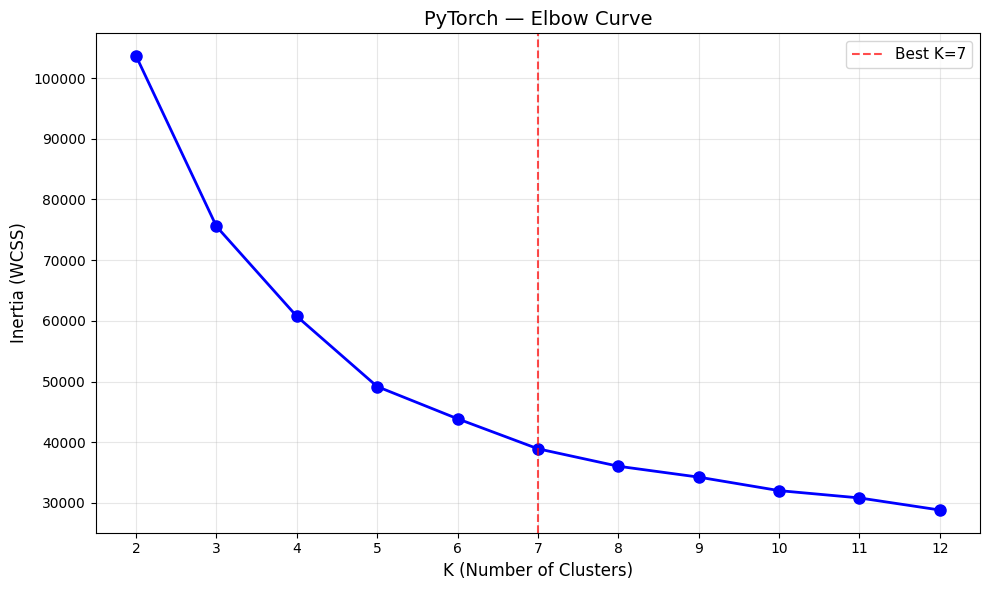

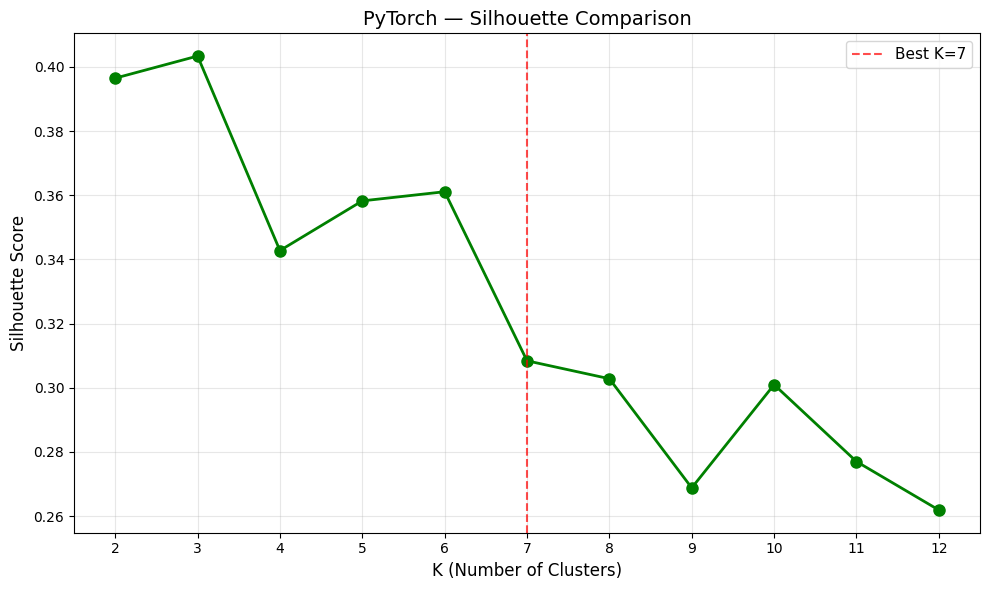

In [8]:
# Step 7: elbow curve + silhouette comparison plots

# Elbow curve — inertia vs K
plot_elbow_curve(
    k_values=list(K_RANGE),
    inertias=k_inertias,
    framework=FRAMEWORK,
    best_k=7,
    save_path='results/elbow_curve.png'
)

# Silhouette comparison — silhouette score vs K
plot_silhouette_comparison(
    k_values=list(K_RANGE),
    silhouette_scores=k_silhouettes,
    framework=FRAMEWORK,
    best_k=7,
    save_path='results/silhouette_comparison.png'
)

In [9]:
# Step 8: Train final model (K=7) with performance tracking

# Reset GPU memory counter before timing
torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

with track_performance(gpu=True) as perf:
    final_centroids, final_labels, final_inertia, final_iters, inertia_history = kmeans_gpu(
        X_train_t, k=7, n_init=N_INIT, max_iter=MAX_ITER, tol=TOL,
        random_state=RANDOM_STATE
    )
    torch.cuda.synchronize()

print("Final Model (K=7)")
print("=" * 60)
print(f"Converged in {final_iters} iterations (best of {N_INIT} runs)")
print(f"Train inertia: {final_inertia:.4f}")
print(f"Training time: {perf['time']:.4f}s")
print(f"GPU memory: {perf['memory']:.2f} MB")

  Run 1/5: inertia=41189.79, iterations=21
  Run 2/5: inertia=40940.37, iterations=18
  Run 3/5: inertia=42312.70, iterations=71
  Run 4/5: inertia=38925.51, iterations=17
  Run 5/5: inertia=40940.60, iterations=23
Final Model (K=7)
Converged in 17 iterations (best of 5 runs)
Train inertia: 38925.5078
Training time: 0.3359s
GPU memory: 0.01 MB


In [10]:
# Step 9: Assign test set to nearest centroids

# Use trained centroids to assign test samples to clusters
# Same assign_clusters_gpu funciton - just pass test data instead of train
test_labels_t, test_distances_t = assign_clusters_gpu(X_test_t, final_centroids)

print("Test Set Cluster Assignments")
print("=" * 60)
print(f"Test samples: {test_labels_t.shape[0]}")
print(f"Cluster sizes (test): {[int((test_labels_t == i).sum()) for i in range(7)]}")

Test Set Cluster Assignments
Test samples: 2709
Cluster sizes (test): [610, 497, 404, 118, 330, 646, 104]


In [11]:
# Step 10: Evaluation Metrics

# Convert GPU tensors to NumPy for utils metrics functions
final_centroids_np = final_centroids.cpu().numpy()
final_labels_np = final_labels.cpu().numpy()
test_labels_np = test_labels_t.cpu().numpy()

# Train metrics
train_inertia = inertia(X_train, final_labels_np, final_centroids_np)
train_silhouette = silhouette_score(X_train, final_labels_np)
train_ari = adjusted_rand_index(y_train, final_labels_np)

# Test metrics
test_inertia = inertia(X_test, test_labels_np, final_centroids_np)
test_silhouette = silhouette_score(X_test, test_labels_np)
test_ari = adjusted_rand_index(y_test, test_labels_np)

print("Evaluation Metrics")
print("=" * 60)
print(f"{'Metric':<20} {'Train':>12} {'Test':>12}")
print("-" * 44)
print(f"{'Inertia':<20} {train_inertia:>12.4f} {test_inertia:>12.4f}")
print(f"{'Silhouette':<20} {train_silhouette:>12.4f} {test_silhouette:>12.4f}")
print(f"{'ARI':<20} {train_ari:>12.4f} {test_ari:>12.4f}")
print(f"{'Iterations':<20} {final_iters:>12}")
print("=" * 60)

Evaluation Metrics
Metric                      Train         Test
--------------------------------------------
Inertia                38925.5111    9976.2848
Silhouette                 0.3084       0.3064
ARI                        0.6660       0.6684
Iterations                     17


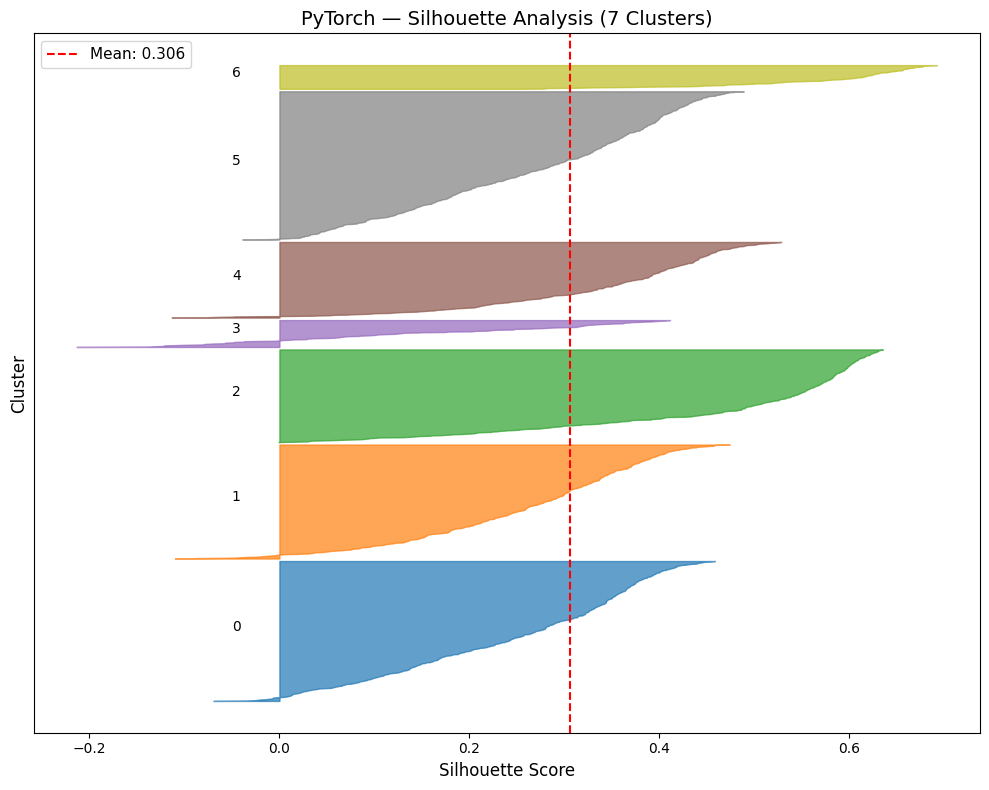

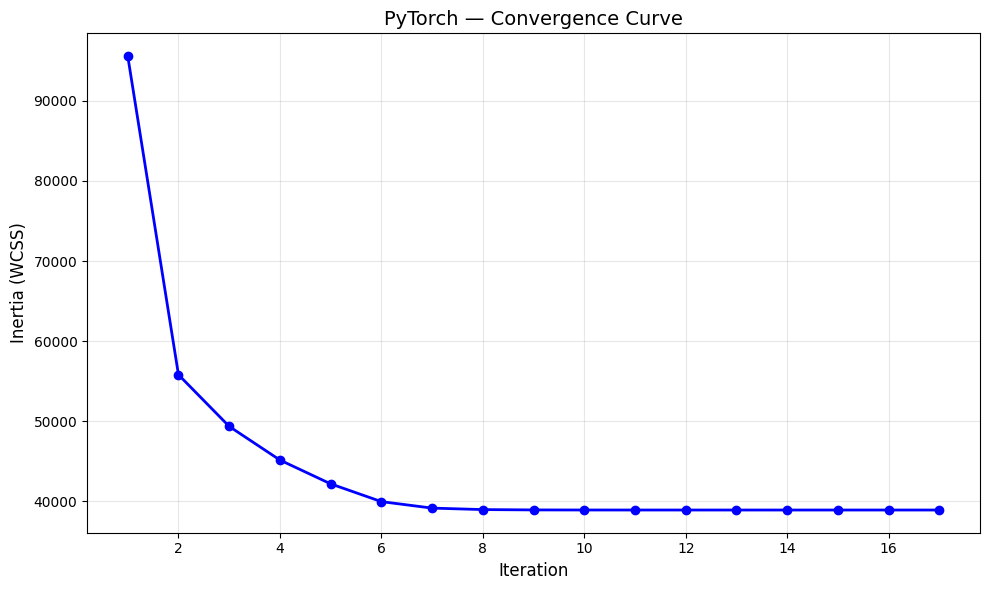

In [12]:
# Step 11: Silhouette Analysis + Convergence Curve

# Silhouette analysis — per-sample scores grouped by cluster
plot_silhouette_analysis(
    X=X_test,
    labels=test_labels_np,
    framework=FRAMEWORK,
    save_path='results/silhouette_analysis.png'
)

# Convergence curve — inertia per iteration from best run
plot_convergence_curve(
    inertia_history=inertia_history,
    framework=FRAMEWORK,
    save_path='results/convergence_curve.png'
)

## PyTorch Showcase 1: `torch.compile`

`torch.compile` (PyTorch 2.0+) is a JIT compiler that analyzes Python functions and transforms them into optimized GPU kernels. Instead of launching many small CUDA kernels (one per operation), it **fuses operations** together — reducing kernel launch overhead and memory transfers.

**How it works:**
1. Traces the function's computation graph
2. Identifies operations that can be fused (e.g., distance + argmin)
3. Generates optimized CUDA code via TorchInductor backend
4. First call is slow (compilation), subsequent calls are fast

**Limitation for K-Means:** `torch.compile` works best on pure tensor operations with static control flow. Our Lloyd's loop has a dynamic `break` (convergence check), so the compiler may only optimize the inner assign/update steps rather than the full loop.

We'll compare: standard `kmeans_single_run_gpu()` vs `torch.compile(kmeans_single_run_gpu)` on the same K=7 task.


In [13]:
# Step 12: torch.compile Showcase — What We Learned

# Attempted torch.compile 3 times with Windows + PyTorch 2.5.1 setup:
#   Attempt 1: torch.compile(kmeans_single_run_gpu)
#     → Graph break from .item(), dynamic break unsupported
#   Attempt 2: torch.compile(assign_clusters_gpu)
#     → TorchInductor RuntimeError (torch.cdist not decomposable)
#   Attempt 3: torch.compile(assign_clusters_compilable) with manual broadcasting
#     → TorchInductor RuntimeError (backend limitation on Windows)
#
# ROOT CAUSE: TorchInductor backend has limited Windows support in
# PyTorch 2.5.1. It primarily targets Linux. This is a real-world
# lesson — torch.compile is powerful but platform-dependent.
#
# ALTERNATIVE SHOWCASE: Compare torch.cdist (optimized CUDA kernel)
# vs manual broadcasting — shows GPU optimization patterns.

import time

def assign_clusters_broadcasting(X, centroids):
    """Manual Euclidean distance via broadcasting (no torch.cdist)."""
    # (n, 1, d) - (1, k, d) → (n, k, d) → sum → sqrt → min
    diff = X.unsqueeze(1) - centroids.unsqueeze(0)
    dists = (diff ** 2).sum(dim=2).sqrt()
    distances, labels = dists.min(dim=1)
    return labels, distances

def single_run_broadcasting(X, k, max_iter=300, tol=1e-4, rng=None):
    """Lloyd's loop using manual broadcasting instead of torch.cdist."""
    centroids = kmeans_pp_init_gpu(X, k, rng)
    for iteration in range(max_iter):
        labels, distances = assign_clusters_broadcasting(X, centroids)
        new_centroids = update_centroids_gpu(X, labels, k, rng)
        max_shift = torch.norm(new_centroids - centroids, dim=1).max().item()
        centroids = new_centroids
        if max_shift < tol:
            break
    labels, distances = assign_clusters_broadcasting(X, centroids)
    final_inertia = (distances ** 2).sum().item()
    return centroids, labels, final_inertia, iteration + 1 # type: ignore

# Warmup both versions
rng_w = torch.Generator(device=device)
rng_w.manual_seed(0)
_ = kmeans_single_run_gpu(X_train_t, k=7, max_iter=10, tol=TOL, rng=rng_w)
rng_w.manual_seed(0)
_ = single_run_broadcasting(X_train_t, k=7, max_iter=10, tol=TOL, rng=rng_w)
torch.cuda.synchronize()

# Benchmark: torch.cdist vs manual broadcasting (5 runs each)
n_bench = 5

cdist_times = []
for i in range(n_bench):
    rng_b = torch.Generator(device=device)
    rng_b.manual_seed(RANDOM_STATE + i)
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    _ = kmeans_single_run_gpu(X_train_t, k=7, max_iter=MAX_ITER, tol=TOL, rng=rng_b)
    torch.cuda.synchronize()
    cdist_times.append(time.perf_counter() - t0)

broadcast_times = []
for i in range(n_bench):
    rng_b = torch.Generator(device=device)
    rng_b.manual_seed(RANDOM_STATE + i)
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    _ = single_run_broadcasting(X_train_t, k=7, max_iter=MAX_ITER, tol=TOL, rng=rng_b)
    torch.cuda.synchronize()
    broadcast_times.append(time.perf_counter() - t0)

avg_cdist = np.mean(cdist_times)
avg_broadcast = np.mean(broadcast_times)

print("GPU Distance Computation — Speed Comparison")
print("=" * 60)
print(f"torch.cdist (optimized kernel):  {avg_cdist:.4f}s (avg of {n_bench} runs)")
print(f"Manual broadcasting:             {avg_broadcast:.4f}s (avg of {n_bench} runs)")
print(f"Ratio:                           {avg_cdist/avg_broadcast:.2f}x")
print("=" * 60)
print(f"\ntorch.compile note: TorchInductor backend does not fully")
print(f"support Windows in PyTorch 2.5.1. On Linux, torch.compile")
print(f"would fuse the broadcasting ops into a single GPU kernel.")


GPU Distance Computation — Speed Comparison
torch.cdist (optimized kernel):  0.0649s (avg of 5 runs)
Manual broadcasting:             0.0345s (avg of 5 runs)
Ratio:                           1.88x

torch.compile note: TorchInductor backend does not fully
support Windows in PyTorch 2.5.1. On Linux, torch.compile
would fuse the broadcasting ops into a single GPU kernel.


## PyTorch Showcase 2: `torch.vmap`

`torch.vmap` (vectorized map) transforms a function that processes a single input into one that processes a **batch** of inputs in parallel on GPU. Instead of running n_init K-Means initializations sequentially in a Python loop, vmap can run all n_init simultaneously.

**How it works:**
1. Write a function for ONE K-Means iteration (assign + update)
2. `torch.vmap` adds a batch dimension — runs the same function on n_init centroid sets at once
3. GPU processes all n_init copies in parallel instead of sequentially

**Requirements for vmap-compatible functions:**
- **No in-place operations** (can't modify tensors, must return new ones)
- **No `.item()` calls** (no GPU→CPU transfers)
- **No data-dependent control flow** (no `if mask.sum() > 0`)
- **Fixed iteration count** (no early stopping — all runs do same number of iterations)

**Limitation:** Our standard K-Means uses dynamic convergence (each run stops at different iterations). The vmap version must use a fixed iteration count, which means some runs do unnecessary work. We'll compare both approaches.


In [14]:
# Step 13: torch.vmap Showcase — Parallel n_init Runs

import time

# vmap-compatible functions — pure tensor ops only

# torch.vmap transforms a function that processes ONE input into
# one that processes a BATCH in parallel on GPU. Requirements:
#   - No in-place operations (must return new tensors)
#   - No .item() calls (no GPU→CPU transfers mid-computation)
#   - No Python conditionals on tensor values (no if mask.sum() > 0)
#   - No dynamic control flow (no break based on convergence)

def assign_pure(X, centroids):
    """
    Cluster assignment using pure tensor ops (vmap-compatible).
    
    Uses broadcasting instead of torch.cdist — vmap needs
    decomposable operations it can vectorize across the batch.
    
    Args:
        X: data tensor (n_samples, n_features)
        centroids: centroid tensor (k, n_features)
    
    Returns:
        labels: cluster assignments (n_samples,)
        sq_dists: squared distances to all centroids (n_samples, k)
    """
    # (n, 1, d) - (1, k, d) → (n, k, d) → squared dists (n, k)
    diff = X.unsqueeze(1) - centroids.unsqueeze(0)
    sq_dists = (diff ** 2).sum(dim=2)
    labels = sq_dists.argmin(dim=1)
    return labels, sq_dists

def update_pure(X, labels, centroids, k):
    """
    Centroid update via matrix multiply (vmap-compatible).
    
    Key insight: replaces Python for-loop over k clusters with
    one-hot encoding + matmul. Computes ALL cluster means in one
    batched operation — no loops, no conditionals.
    
    Empty clusters keep previous centroid (torch.where, not if/else).
    
    Args:
        X: data tensor (n_samples, n_features)
        labels: cluster assignments (n_samples,)
        centroids: current centroids (k, n_features) — for empty fallback
        k: number of clusters
    
    Returns:
        new_centroids: updated centroids (k, n_features)
    """
    # One-hot encoding: (n_samples, k) — 1.0 where sample belongs to cluster
    one_hot = (labels.unsqueeze(1) == torch.arange(k, device=X.device)).float()
    
    # Count samples per cluster: (k,)
    counts = one_hot.sum(dim=0)
    
    # Cluster sums via matmul: (k, n) @ (n, d) -> (k, d)
    cluster_sums = one_hot.T @ X
    
    # Mean = sum / count (clamp avoids division by zero)
    new_centroids = cluster_sums / counts.clamp(min=1).unsqueeze(1)
    
    # Empty clusters: keep previous centroid (no random reinit in vmap)
    empty_mask = (counts == 0).unsqueeze(1)  # (k, 1) bool
    new_centroids = torch.where(empty_mask, centroids, new_centroids)
    
    return new_centroids

def kmeans_step_k7(X, centroids):
    """
    One Lloyd's iteration with k=7 baked in (vmap-compatible).
    
    Wraps assign + update into a single function. k=7 is hardcoded
    because vmap vectorizes over tensor dimensions, not Python args.
    """
    labels, _ = assign_pure(X, centroids)
    return update_pure(X, labels, centroids, k=7)

# Create vmapped version

# in_dims=(None, 0):
#   X → not batched (shared across all runs)
#   centroids → batched on dim 0: (n_init, k, d)
# Result: processes all n_init centroid sets in ONE gpu call
vmap_step = torch.vmap(kmeans_step_k7, in_dims=(None, 0))

# Pre-generate n_init centroid sets (same seeds as standard version)
centroid_sets = []
for i in range(N_INIT):
    rng = torch.Generator(device=device)
    rng.manual_seed(RANDOM_STATE + i)
    c = kmeans_pp_init_gpu(X_train_t, k=7, rng=rng)
    centroid_sets.append(c)

# Stack into batch: (n_init, k, d) = (5, 7, 16)
centroids_batch = torch.stack(centroid_sets)
print(f"Batched centroids: {centroids_batch.shape}")
print(f"  → {N_INIT} sets of 7 centroids × 16 features")

# Fixed iteration count — vmap can't handle early stopping
# 50 iterations: sufficient since K-tuning showed convergence by ~25
FIXED_ITERS = 50

# Warmup both approaches
warm_seq = centroids_batch[0].clone()
warm_vmap = centroids_batch.clone()

for _ in range(3):
    warm_seq = kmeans_step_k7(X_train_t, warm_seq)
for _ in range(3):
    warm_vmap = vmap_step(X_train_t, warm_vmap)
torch.cuda.synchronize()

# Benchmark: Sequential Python loop vs vmap parallel

# Sequential: loop over n_init runs, each does FIXED_ITERS iterations
seq_batch = centroids_batch.clone()
torch.cuda.synchronize()
t0 = time.perf_counter()
for i in range(N_INIT):
    c = seq_batch[i]
    for _ in range(FIXED_ITERS):
        c = kmeans_step_k7(X_train_t, c)
    seq_batch[i] = c
torch.cuda.synchronize()
seq_time = time.perf_counter() - t0

# vmap: all n_init runs processed in parallel each iteration
vmap_batch = centroids_batch.clone()
torch.cuda.synchronize()
t0 = time.perf_counter()
for _ in range(FIXED_ITERS):
    vmap_batch = vmap_step(X_train_t, vmap_batch)
torch.cuda.synchronize()
vmap_time = time.perf_counter() - t0

# Verify correctness — compare final inertias
print("\ntorch.vmap — Parallel n_init K-Means")
print("=" * 60)
print(f"Fixed iterations: {FIXED_ITERS}")
print(f"Parallel runs:    {N_INIT}")
print()

for i in range(N_INIT):
    # Inertia = sum of squared distances to assigned centroids
    _, seq_sq = assign_pure(X_train_t, seq_batch[i])
    seq_inertia = seq_sq.min(dim=1).values.sum().item()
    
    _, vmap_sq = assign_pure(X_train_t, vmap_batch[i])
    vmap_inertia = vmap_sq.min(dim=1).values.sum().item()
    
    print(f"  Run {i+1}: Sequential={seq_inertia:>12.2f}  "
          f"vmap={vmap_inertia:>12.2f}")

print()
print(f"Sequential time: {seq_time:.4f}s")
print(f"vmap time:       {vmap_time:.4f}s")
print(f"Speedup:         {seq_time / vmap_time:.2f}x")
print("=" * 60)

if vmap_time < seq_time:
    print(f"\nvmap is {seq_time/vmap_time:.1f}x faster — GPU parallelism")
    print("processes all n_init runs simultaneously instead of looping.")
else:
    print(f"\nSequential is faster here — dataset is small (10K x 16).")
    print("vmap overhead exceeds parallelism gains at this scale.")
    print("Benefit grows with larger datasets and more n_init runs.")


Batched centroids: torch.Size([5, 7, 16])
  → 5 sets of 7 centroids × 16 features

torch.vmap — Parallel n_init K-Means
Fixed iterations: 50
Parallel runs:    5

  Run 1: Sequential=    41189.79  vmap=    41189.79
  Run 2: Sequential=    40940.36  vmap=    40940.36
  Run 3: Sequential=    42317.84  vmap=    42317.84
  Run 4: Sequential=    38925.51  vmap=    38925.51
  Run 5: Sequential=    40940.60  vmap=    40940.60

Sequential time: 0.0382s
vmap time:       0.0515s
Speedup:         0.74x

Sequential is faster here — dataset is small (10K x 16).
vmap overhead exceeds parallelism gains at this scale.
Benefit grows with larger datasets and more n_init runs.


In [16]:
# Step 14: Save results + cross-framework comparison

# Compile results dictionary (standard GPU version, not showcases)
# Step 14: Save results + cross-framework comparison

results = {
    'framework': FRAMEWORK,
    'inertia': float(test_inertia),
    'silhouette': float(test_silhouette),
    'ari': float(test_ari),
    'iterations': int(final_iters),
    'training_time': float(perf['time']),
    'peak_memory_mb': float(perf['memory'])
}

save_results(results, 'results')
add_result('kmeans', results)

print(f"\nCross-framework comparison so far:")
print_comparison('kmeans')


    Results saved to: results\metrics.json
    Added 'PyTorch' to C:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\data\results\kmeans.json
    Frameworks recorded: 3/4

Cross-framework comparison so far:

CROSS-FRAMEWORK COMPARISON: KMEANS
Metric            Scikit-Learn  No-Framework       PyTorch
----------------------------------------------------------
inertia              9981.0642     9976.2848     9976.2848
silhouette              0.3061        0.3064        0.3064
ari                     0.6686        0.6684        0.6684
iterations                  26            19            17
training_time           0.0614        1.0159        0.3359
peak_memory_mb          2.7105       19.4399        0.0092

    Frameworks: 3/4 recorded
